<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/PYT_SBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
from torch_geometric.data import Data
import numpy as np
import re
from Bio import PDB

# List of standard amino acids
AMINO_ACIDS = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
]

# Generate one-hot encoding dictionary
AA_ONE_HOT = {aa: np.eye(len(AMINO_ACIDS))[i] for i, aa in enumerate(AMINO_ACIDS)}

# Physicochemical properties + One-Hot encoding
AA_PROPERTIES = {
    aa: [hydrophobic, polarity, charge] + list(AA_ONE_HOT[aa])
    for aa, (hydrophobic, polarity, charge) in {
        "ALA": [1, 0, 0], "ARG": [0, 1, 1], "ASN": [0, 1, 0], "ASP": [0, 1, -1], "CYS": [1, 0, 0],
        "GLN": [0, 1, 0], "GLU": [0, 1, -1], "GLY": [1, 0, 0], "HIS": [0, 1, 1], "ILE": [1, 0, 0],
        "LEU": [1, 0, 0], "LYS": [0, 1, 1], "MET": [1, 0, 0], "PHE": [1, 0, 0], "PRO": [1, 0, 0],
        "SER": [0, 1, 0], "THR": [0, 1, 0], "TRP": [1, 0, 0], "TYR": [1, 0, 0], "VAL": [1, 0, 0]
    }.items()
}


def extract_binding_sites_from_pdb(pdb_file):
    """
    Extracts binding site information from SITE records in a PDB file.
    Returns a dictionary mapping binding site names to involved residues.
    """
    binding_sites = {}  # Store binding site info
    site_id = 1  # Assign unique numerical IDs to binding sites

    with open(pdb_file, "r") as file:
        for line in file:
            if line.startswith("SITE"):
                parts = line.split()
                site_name = parts[2]  # Extract binding site name (e.g., "AC1", "AC2", etc.)

                # Extract residue details (chain, residue number, residue name)
                for i in range(4, len(parts), 3):
                    if i + 2 < len(parts):  # Ensure valid residue triplet
                        res_name = parts[i]  # Residue name (e.g., TYR)
                        chain_id = parts[i + 1]  # Chain ID (e.g., C)
                        res_id = int(parts[i + 2])  # Residue sequence number (e.g., 89)

                        # Store binding site info
                        if site_name not in binding_sites:
                            binding_sites[site_name] = {"category": site_id, "residues": []}
                            site_id += 1  # Assign a new unique binding site ID

                        binding_sites[site_name]["residues"].append((chain_id, res_id, res_name))



    return binding_sites

def compute_edges(residue_positions, cutoff=8.0):
    """
    Computes edges between residues based on Cα atom distances.
    """
    edges = []
    residue_ids = list(residue_positions.keys())
    coords = np.array([residue_positions[rid] for rid in residue_ids])

    for i in range(len(residue_ids)):
        for j in range(i + 1, len(residue_ids)):  # Avoid duplicate pairs
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= cutoff:
                edges.append((residue_ids[i], residue_ids[j]))

    return edges

def create_protein_graph(pdb_file):
    """
    Creates a PyTorch Geometric graph for an entire protein.
    Each node represents a residue with features:
    - Binding site category
    - Hydrophobicity
    - Polarity
    - Charge
    - Residue name (stored separately)
    """
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    residue_positions = {}
    residue_features = []
    residue_labels = {}  # Stores binding site labels
    residue_names = []   # ✅ Stores residue names (ordered by node index)

    # Extract residue coordinates and features
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue, standard=True):  # Skip non-amino acids
                    res_id = (chain.id, residue.id[1])  # Unique residue identifier
                    if "CA" in residue:  # Use Cα atom for positioning
                        residue_positions[res_id] = residue["CA"].coord

                    # Get residue properties (hydrophobicity, polarity, charge)
                    aa_name = residue.resname
                    features = AA_PROPERTIES.get(aa_name, [0, 0, 0])  # Default to neutral
                    residue_features.append(features)
                    residue_labels[res_id] = 0  # Default to non-binding
                    residue_names.append(aa_name)  # ✅ Store only residue name, not chain/position

    # Get binding site information
    binding_sites = extract_binding_sites_from_pdb(pdb_file)

    # ✅ Fix: Ensure residues are correctly labeled as binding sites
    for site_id, site_info in binding_sites.items():
        category_id = site_info["category"]  # Unique ID per binding site
        for chain, res_id, _ in site_info["residues"]:  # Ignore res_name
            if (chain, res_id) in residue_labels:
                residue_labels[(chain, res_id)] = category_id

    # Convert binding site labels to tensor format
    node_labels = torch.tensor([residue_labels[rid] for rid in residue_positions.keys()], dtype=torch.float)

    # Compute edges
    edges = compute_edges(residue_positions)
    residue_index = {rid: i for i, rid in enumerate(residue_positions.keys())}
    edge_index = torch.tensor([[residue_index[r1], residue_index[r2]] for r1, r2 in edges]).t()

    # Convert features to tensor and add binding site information
    node_features = torch.tensor(residue_features, dtype=torch.float)
    node_features = torch.cat((node_features, node_labels.unsqueeze(1)), dim=1)  # Append binding site category

    return Data(x=node_features, edge_index=edge_index, y=node_labels), residue_index, residue_names


In [58]:
import pandas as pd
from tabulate import tabulate

def print_node_info(protein_graph, residue_index, residue_names, node_idx):
    """
    Pretty prints the feature and connectivity information for a specific node in the protein graph.

    :param protein_graph: PyTorch Geometric Data object
    :param residue_index: Dictionary mapping (chain_id, res_id) -> node index
    :param residue_names: List storing amino acid names indexed by node index
    :param node_idx: Index of the node (residue) to inspect
    """
    # Get feature vector for the node
    node_features = protein_graph.x[node_idx].tolist()

    # Extract residue metadata
    index_to_residue = {v: k for k, v in residue_index.items()}  # Reverse mapping
    chain_id, res_id = index_to_residue[node_idx]  # Get chain & position
    residue_name = residue_names[node_idx]  # Residue name

    # Extract different feature components
    hydrophobicity, polarity, charge = node_features[:3]
    one_hot_encoding = node_features[3:-1]  # All but last (one-hot encoded amino acids)
    binding_site = node_features[-1]  # Last feature is binding site category

    # Get neighbors (connected nodes)
    connected_nodes = protein_graph.edge_index[1][protein_graph.edge_index[0] == node_idx].tolist()

    # Prepare DataFrame for better visualization
    feature_names = ["Hydrophobicity", "Polarity", "Charge"] + AMINO_ACIDS + ["Binding Site Category"]
    feature_values = [hydrophobicity, polarity, charge] + one_hot_encoding + [binding_site]

    df = pd.DataFrame({"Feature": feature_names, "Value": feature_values})

    print(f"\n=== Residue Information for Node {node_idx} ===")
    print(f"Residue: {residue_name}  |  Chain: {chain_id}  |  Position: {res_id}")
    print("\nResidue Properties:\n")
    print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

    print(f"\n🔗 Connected Residues (Neighbors): {connected_nodes}")

# Example Usage
node_index = 5  # Choose a node to inspect
print_node_info(protein_graph, residue_index, residue_names, node_index)




=== Residue Information for Node 5 ===
Residue: ILE  |  Chain: A  |  Position: 6

Residue Properties:

╒════╤═══════════════════════╤═════════╕
│    │ Feature               │   Value │
╞════╪═══════════════════════╪═════════╡
│  0 │ Hydrophobicity        │       1 │
├────┼───────────────────────┼─────────┤
│  1 │ Polarity              │       0 │
├────┼───────────────────────┼─────────┤
│  2 │ Charge                │       0 │
├────┼───────────────────────┼─────────┤
│  3 │ ALA                   │       0 │
├────┼───────────────────────┼─────────┤
│  4 │ ARG                   │       0 │
├────┼───────────────────────┼─────────┤
│  5 │ ASN                   │       0 │
├────┼───────────────────────┼─────────┤
│  6 │ ASP                   │       0 │
├────┼───────────────────────┼─────────┤
│  7 │ CYS                   │       0 │
├────┼───────────────────────┼─────────┤
│  8 │ GLN                   │       0 │
├────┼───────────────────────┼─────────┤
│  9 │ GLU                   │     

In [54]:
binding_sites = extract_binding_sites_from_pdb("1uv6.pdb")
print(binding_sites)

{'AC1': {'category': 1, 'residues': [('C', 89, 'TYR'), ('C', 143, 'TRP'), ('C', 144, 'THR'), ('D', 104, 'ARG'), ('D', 112, 'LEU'), ('D', 114, 'MET')]}, 'AC2': {'category': 2, 'residues': [('D', 89, 'TYR'), ('D', 143, 'TRP'), ('D', 144, 'THR'), ('D', 185, 'TYR'), ('E', 104, 'ARG'), ('E', 112, 'LEU'), ('E', 114, 'MET')]}, 'AC3': {'category': 3, 'residues': [('F', 104, 'ARG'), ('F', 112, 'LEU'), ('J', 89, 'TYR'), ('J', 143, 'TRP'), ('J', 144, 'THR')]}}


In [55]:
pdb_file = "1uv6.pdb"
protein_graph, _, _ = create_protein_graph(pdb_file) # Unpack the tuple to get the Data object

print(protein_graph)
print("Feature Matrix Shape:", protein_graph.x.shape)
print("Number of Nodes:", protein_graph.x.shape[0])
print("Number of Edges:", protein_graph.edge_index.shape[1])


Data(x=[2050, 24], edge_index=[2, 10335], y=[2050])
Feature Matrix Shape: torch.Size([2050, 24])
Number of Nodes: 2050
Number of Edges: 10335


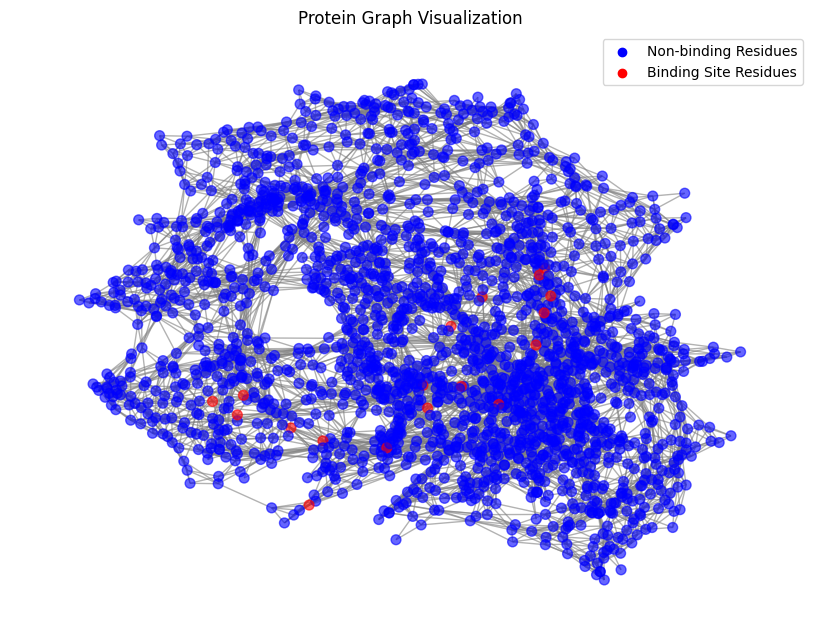

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_protein_graph(protein_graph, title="Protein Graph Visualization"):
    """
    Visualizes the protein graph using NetworkX and Matplotlib.
    Nodes are colored based on binding site labels.
    """
    # Convert PyTorch Geometric graph to NetworkX
    G = to_networkx(protein_graph, to_undirected=True)

    # Get node positions using a force-directed layout
    pos = nx.spring_layout(G, seed=42)

    # Extract binding site information from the node feature matrix
    binding_site_labels = protein_graph.y.numpy()

    # Define node colors:
    # - Non-binding residues (0) are blue
    # - Binding site residues (any other ID) are red
    node_colors = ["red" if label > 0 else "blue" for label in binding_site_labels]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.6)

    # Legend
    plt.scatter([], [], color="blue", label="Non-binding Residues")
    plt.scatter([], [], color="red", label="Binding Site Residues")
    plt.legend(loc="upper right")

    plt.title(title)
    plt.show()

# Call the function to visualize the graph
visualize_protein_graph(protein_graph)
